In [1]:
import requests
import pandas as pd
from datetime import datetime

def fetch_yahoo_news_api(ticker, count=20):
    url = (
        f"https://query1.finance.yahoo.com/v1/finance/search?"
        f"q={ticker}&newsCount={count}&quotesCount=0"
    )
    headers = {
        "User-Agent": "Mozilla/5.0"
    }

    r = requests.get(url, headers=headers).json()

    if "news" not in r:
        return pd.DataFrame()  # no news found

    rows = []
    for item in r["news"]:
        try:
            title = item.get("title")
            link = item.get("link")
            publisher = item.get("publisher")
            ts = item.get("providerPublishTime")
            dt = datetime.utcfromtimestamp(ts)

            rows.append({
                "ticker": ticker,
                "title": title,
                "publisher": publisher,
                "datetime": dt,
                "url": link,
            })
        except:
            continue

    return pd.DataFrame(rows)


In [2]:
df_news = fetch_yahoo_news_api("AAPL", 20)
print(df_news.head(10))


  ticker                                              title       publisher  \
0   AAPL  Winning Stocks Keep Winning, And That’s What i...   24/7 Wall St.   
1   AAPL  Could Nvidia Become the First $10 Trillion Com...     Motley Fool   
2   AAPL  Meta (META) Stock Pops Following Metaverse Cut...   24/7 Wall St.   
3   AAPL           Apple Is Richer Than All but 4 Countries  GOBankingRates   
4   AAPL  Corporate America is scrambling to hire energy...   Yahoo Finance   
5   AAPL  Not 'very hawkish at all': Wall Street optimis...   Yahoo Finance   
6   AAPL  The Smartest Mining Stock to Buy With $100 Rig...     Motley Fool   
7   AAPL  Prediction: This AI Stock Could Lead the Marke...     Motley Fool   
8   AAPL  Investor Who Reached $10K/Month in Dividend In...        Benzinga   
9   AAPL  2 Stocks That Turned $1,000 Into $1 Million (o...     Motley Fool   

             datetime                                                url  
0 2025-12-14 19:22:02  https://finance.yahoo.com/m/2b39

In [3]:
df_news = fetch_yahoo_news_api("AAPL")
df_news["date"] = df_news["datetime"].dt.date
news_by_day = df_news.groupby("date")["title"].apply(list)


In [9]:
news_by_day

date
2025-12-02    [Apple's 6 straight records, bitcoin recovery:...
2025-12-03    [Apple’s AI Troubles Are Fading. Just Look at ...
Name: title, dtype: object

date
2025-12-02    8
2025-12-03    2
Name: count, dtype: int64


<Axes: xlabel='date'>

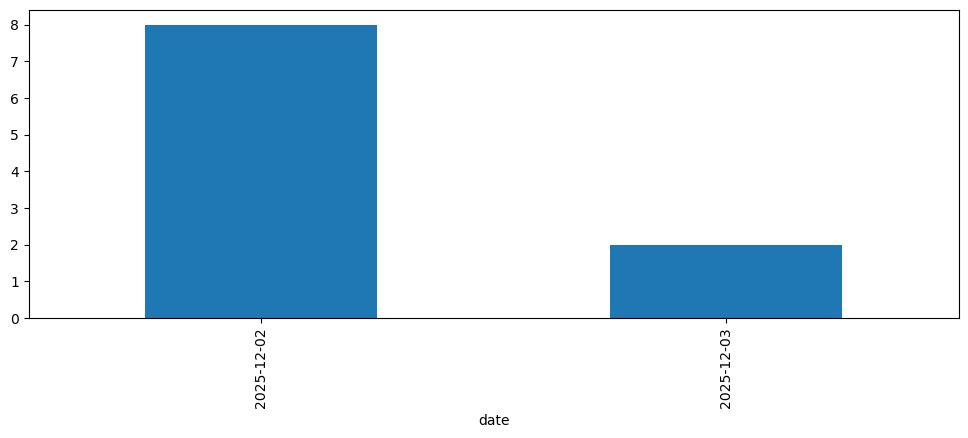

In [10]:
news_counts = df_news['date'].value_counts().sort_index()
print(news_counts)
news_counts.plot(kind='bar', figsize=(12,4))


In [11]:
df_news[df_news['url'].isna()]


,ticker,title,publisher,datetime,url,date


In [12]:
df_news['publisher'].value_counts()


publisher
Barrons.com            3
Yahoo Finance Video    2
Investopedia           1
Simply Wall St.        1
MT Newswires           1
Motley Fool            1
Zacks                  1
Name: count, dtype: int64

In [ ]:
import numpy as np

def embed_day_articles(titles, ticker):
    vectors = []
    for title in titles:
        v = generate_embedding(title, ticker)
        if v is not None:
            vectors.append(v)
    if len(vectors) == 0:
        return np.zeros(8)
    return np.mean(vectors, axis=0)     # aggregate daily sentiment


In [4]:
from gnews import GNews
import pandas as pd
from datetime import datetime

def fetch_gnews(ticker, start_date, end_date):
    google = GNews(
        language='en',
        country='US',
        max_results=100  # IMPORTANT: must be <= 100 for date filtering to work
    )

    # Set date filter
    google.start_date = pd.to_datetime(start_date).to_pydatetime()
    google.end_date = pd.to_datetime(end_date).to_pydatetime()

    # FIX: remove spaces from query
    query = f"{ticker} stock".replace(" ", "+")

    articles = google.get_news(query)
    rows = []

    for a in articles:
        try:
            dt = pd.to_datetime(a["published date"])
        except:
            dt = None

        rows.append({
            "ticker": ticker,
            "title": a["title"],
            "publisher": a["publisher"]["title"] if "publisher" in a else "",
            "datetime": dt,
            "url": a["url"]
        })

    df = pd.DataFrame(rows)
    df = df.sort_values("datetime", ascending=False).reset_index(drop=True)
    return df


In [5]:
df_gnews = fetch_gnews("AAPL", "2024-11-01", "2024-12-01")
print(df_gnews.head(10))
print(len(df_gnews))


  ticker                                              title  \
0   AAPL  Apple (APPL) Stock Eyes $1T in Gains, Analyst ...   
1   AAPL  4 Reasons to Buy Apple Stock Like There's No T...   
2   AAPL  Apple (APPL) Stock Eyes $1T in Gains, Analyst ...   
3   AAPL  Warren Buffett Has Been Dumping Apple Stock fo...   
4   AAPL  Apple Inc (AAPL) DCF Valuation: Is The Stock U...   
5   AAPL  Apple Inc. (AAPL): Developing Advanced LLM Sir...   
6   AAPL  Apple (AAPL) Surged After Solid Earnings Repor...   
7   AAPL  Here is Why Warren Buffett Sold AAPL Stock - Y...   
8   AAPL  Is Apple Inc. (AAPL) Still a Key Fixture in Wa...   
9   AAPL  Could Buying Apple Stock Today Set You Up for ...   

                 publisher            datetime  \
0             Watcher Guru 2024-12-01 08:00:00   
1          The Motley Fool 2024-12-01 08:00:00   
2               CryptoRank 2024-12-01 08:00:00   
3          The Motley Fool 2024-11-30 08:00:00   
4  The Acquirer's Multiple 2024-11-28 08:00:00   
5     

In [6]:
import requests
import pandas as pd
from datetime import datetime, timedelta

def fetch_reddit_search(ticker, days=7, max_posts=200):
    url = "https://www.reddit.com/search.json"
    headers = {"User-Agent": "Mozilla/5.0"}

    rows = []
    after_date = datetime.utcnow() - timedelta(days=days)
    after_timestamp = int(after_date.timestamp())

    params = {
        "q": f"{ticker}",
        "sort": "new",
        "limit": 100,   # Reddit max
        "t": "year"     # allow older results but we will filter manually
    }

    response = requests.get(url, params=params, headers=headers)

    if response.status_code != 200:
        print("Reddit API blocked:", response.status_code)
        return pd.DataFrame()

    data = response.json()

    for post in data["data"]["children"]:
        info = post["data"]

        ts = info.get("created_utc")
        if ts is None:
            continue

        dt = datetime.utcfromtimestamp(ts)

        # filter by days
        if dt < after_date:
            continue

        rows.append({
            "ticker": ticker,
            "subreddit": info.get("subreddit"),
            "title": info.get("title"),
            "text": info.get("selftext"),
            "datetime": dt,
            "url": "https://reddit.com" + info.get("permalink"),
            "score": info.get("score")
        })

        if len(rows) >= max_posts:
            break

    return pd.DataFrame(rows)


In [7]:
df_reddit = fetch_reddit_search("AAPL", days=7, max_posts=50)
print(df_reddit.head())
print(len(df_reddit))


Reddit API blocked: 403
Empty DataFrame
Columns: []
Index: []
0


In [8]:
import feedparser
import pandas as pd
from datetime import datetime

def parse_rss(url, ticker):
    feed = feedparser.parse(url)
    rows = []

    for entry in feed.entries:
        title = entry.get("title", "")
        link = entry.get("link", "")
        published = entry.get("published", "")

        # Convert datetime safely
        try:
            dt = datetime(*entry.published_parsed[:6])
        except:
            dt = None

        rows.append({
            "ticker": ticker,
            "title": title,
            "publisher": url.split("//")[1].split("/")[0],  # domain name
            "datetime": dt,
            "url": link
        })

    return pd.DataFrame(rows)


In [9]:
RSS_FEEDS = [
    "https://www.cnbc.com/id/10001147/device/rss/rss.html",          # CNBC Markets
    "https://www.reuters.com/finance/markets/rss",                  # Reuters Markets
    "https://www.marketwatch.com/rss/topstories",                   # MarketWatch
    "https://www.nasdaq.com/feed/rssoutbound?category=Stock-Market",
    "https://feeds.a.dj.com/rss/RSSMarketsMain.xml",                # WSJ Markets
    "https://finance.yahoo.com/rss/topstories",                     # Yahoo RSS
    "https://www.investing.com/rss/news_25.rss",                    # Investing.com
]


In [10]:
def fetch_rss_news(ticker):
    dfs = []
    for feed in RSS_FEEDS:
        try:
            df = parse_rss(feed, ticker)
            dfs.append(df)
        except Exception as e:
            print("RSS Error:", feed, e)

    if len(dfs) == 0:
        return pd.DataFrame()

    df_all = pd.concat(dfs, ignore_index=True)
    df_all = df_all.dropna(subset=["title"])
    df_all["datetime"] = pd.to_datetime(df_all["datetime"], errors="coerce")

    return df_all.reset_index(drop=True)


In [11]:
df_rss = fetch_rss_news("AAPL")
print(df_rss.head(10))
print("Total RSS articles:", len(df_rss))


KeyboardInterrupt: 

In [12]:
import pandas as pd
from datetime import timedelta

def unify_news_sources(df_yahoo, df_google, df_rss):
    # --- Combine all sources ---
    df = pd.concat([df_yahoo, df_google, df_rss], ignore_index=True)
    
    # --- Remove rows with missing title ---
    df = df.dropna(subset=["title"]).reset_index(drop=True)

    # --- Normalize title (remove punctuation / lowercase) ---
    df["title_norm"] = (
        df["title"]
        .str.lower()
        .str.replace(r"[^a-z0-9 ]", "", regex=True)
        .str.replace(r"\s+", " ", regex=True)
        .str.strip()
    )

    # --- FIRST PASS DEDUP: exact match on normalized title ---
    df = df.drop_duplicates(subset=["title_norm"], keep="first")

    # --- SECOND PASS DEDUP: group by similar timestamps ---
    df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")

    df = df.sort_values("datetime").reset_index(drop=True)

    rows = []
    last_title = None
    last_time = None

    for _, row in df.iterrows():
        if last_title == row["title_norm"] and last_time is not None:
            if abs(row["datetime"] - last_time) < timedelta(hours=1):
                continue  # skip near-duplicate article

        rows.append(row)
        last_title = row["title_norm"]
        last_time = row["datetime"]

    df_clean = pd.DataFrame(rows).drop(columns=["title_norm"]).reset_index(drop=True)
    return df_clean


In [13]:
# --- Fetch news ---
df_yahoo = fetch_yahoo_news_api("AAPL", count=100)
df_yahoo["source"] = "yahoo"

df_google = fetch_gnews(
    "AAPL",
    start_date="2016-01-01",
    end_date="2024-12-31"
)
df_google["source"] = "google"

# --- Combine ONLY Yahoo + Google ---
df_all = pd.concat([df_yahoo, df_google], ignore_index=True)

# --- Basic cleaning ---
df_all["datetime"] = pd.to_datetime(df_all["datetime"], errors="coerce")
df_all = df_all.dropna(subset=["datetime", "title"])

# --- Create daily key for LSTM alignment ---
df_all["date"] = df_all["datetime"].dt.date
df_all["date"] = pd.to_datetime(df_all["date"])

# --- Sort ---
df_all = df_all.sort_values(["date", "datetime"]).reset_index(drop=True)

print(df_all.head(20))
print("Total articles:", len(df_all))


   ticker                                              title        publisher  \
0    AAPL  Apple (AAPL) Stock: Peter Thiel is Right: The ...    US News Money   
1    AAPL  Is Apple Stock Really Worth $150? - US News Money    US News Money   
2    AAPL  Apple (AAPL) Stock vs. Alphabet (GOOG) Stock: ...    US News Money   
3    AAPL  Apple Stock Smashes Previous All-Time High For...        MacRumors   
4    AAPL  Apple, Inc.'s 10.5% Dividend Increase Is Disap...  The Motley Fool   
5    AAPL  Slide in AAPL stock price continues into 5th d...          9to5Mac   
6    AAPL  How iPhone X TrueDepth Camera Could Boost Appl...    InvestorPlace   
7    AAPL  Is Apple Ready for Another Stock Split in 2018...  The Motley Fool   
8    AAPL  The iPhone 8 Is a Disappointment For Apple Inc...    US News Money   
9    AAPL  Why 3 Value Experts Say Apple Stock Is Still A...           Forbes   
10   AAPL  Apple Stock Soars on $100 Billion Buyback - US...    US News Money   
11   AAPL  Apple (AAPL) Stoc

In [ ]:
# Align to LSTM trading days
market_df = pd.read_csv("sp500_features.csv", parse_dates=["date"])

aapl_trading_days = set(
    market_df[market_df["ticker"] == "AAPL"]["date"].unique()
)

df_all = df_all[df_all["date"].isin(aapl_trading_days)]

print("After alignment:", len(df_all))


In [ ]:
import os
import shutil
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# -----------------------------
# 1. Clear ALL HF caches in HOME
# -----------------------------
home_paths = [
    os.path.expanduser("~/.cache/huggingface"),
    os.path.expanduser("~/.cache/torch"),
    os.path.expanduser("~/.huggingface"),
    os.path.expanduser("~/.local/share/huggingface"),
]
for p in home_paths:
    if os.path.exists(p):
        shutil.rmtree(p, ignore_errors=True)

# -------------------------------------------
# 2. Create scratch directory for HF caching
# -------------------------------------------
SCRATCH_CACHE = f"/scratch/scholar/{os.environ['USER']}/hf_cache"
os.makedirs(SCRATCH_CACHE, exist_ok=True)

# -----------------------------------------
# 3. Set ALL important cache environment vars
# -----------------------------------------
os.environ["HF_HOME"] = SCRATCH_CACHE
os.environ["HF_DATASETS_CACHE"] = SCRATCH_CACHE
os.environ["HF_HUB_CACHE"] = SCRATCH_CACHE
os.environ["TRANSFORMERS_CACHE"] = SCRATCH_CACHE
os.environ["HUGGINGFACE_HUB_CACHE"] = SCRATCH_CACHE
os.environ["XDG_CACHE_HOME"] = SCRATCH_CACHE
os.environ["XDG_DATA_HOME"] = SCRATCH_CACHE

print("Using cache directory:", SCRATCH_CACHE)

# -----------------------------------------
# 4. TEST: load SMALL Qwen model (0.5B)
# -----------------------------------------
model_name = "Qwen/Qwen2.5-0.5B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=SCRATCH_CACHE)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto",
    cache_dir=SCRATCH_CACHE
)

print("SUCCESS: Model loaded without using HOME directory!")


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import json
import re

model_name = "Qwen/Qwen2.5-1.5B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)

EMBED_SYSTEM_PROMPT = """
You are a financial news embedding model. Your task is to convert financial text
into a JSON object with EXACTLY 8 numeric features. Each value must be a float
in the range [-1, 1].

The 8 features are:
1. polarity       (negative → positive sentiment)
2. intensity      (strength of sentiment)
3. relevance      (how directly it relates to TARGET_TICKER)
4. short_term     (expected next-day price impact)
5. long_term      (expected multi-week impact)
6. volatility     (uncertainty implied by the text)
7. novelty        (new vs repeated information)
8. credibility    (rumor → fact-based)

You MUST output only a JSON object with these 8 fields.

--------------------------------------------------------
FEW-SHOT EXAMPLES
--------------------------------------------------------

Example A:
TEXT: "Netflix subscriber growth slows as competition intensifies across streaming platforms."
TARGET_TICKER: NFLX

OUTPUT:
{
  "polarity": -0.50,
  "intensity": 0.70,
  "relevance": 0.95,
  "short_term": -0.40,
  "long_term": -0.20,
  "volatility": 0.60,
  "novelty": 0.55,
  "credibility": 0.90
}

Example B:
TEXT: "Coca-Cola reports strong international sales and raises full-year outlook."
TARGET_TICKER: KO

OUTPUT:
{
  "polarity": 0.60,
  "intensity": 0.55,
  "relevance": 0.90,
  "short_term": 0.35,
  "long_term": 0.50,
  "volatility": 0.20,
  "novelty": 0.30,
  "credibility": 0.95
}

Example C:
TEXT: "Boeing receives a major multi-billion dollar aircraft order from a Middle Eastern airline."
TARGET_TICKER: BA

OUTPUT:
{
  "polarity": 0.80,
  "intensity": 0.85,
  "relevance": 1.00,
  "short_term": 0.70,
  "long_term": 0.75,
  "volatility": 0.40,
  "novelty": 0.70,
  "credibility": 0.95
}

Example D:
TEXT: "Meta Faces a global outage across Instagram and Facebook services."
TARGET_TICKER: META

OUTPUT:
{
  "polarity": -0.75,
  "intensity": 0.80,
  "relevance": 1.00,
  "short_term": -0.60,
  "long_term": -0.35,
  "volatility": 0.85,
  "novelty": 0.65,
  "credibility": 0.90
}

Example E:
TEXT: "Oil prices rise as OPEC announces unexpected production cuts."
TARGET_TICKER: XLE

OUTPUT:
{
  "polarity": 0.30,
  "intensity": 0.65,
  "relevance": 0.85,
  "short_term": 0.40,
  "long_term": 0.25,
  "volatility": 0.70,
  "novelty": 0.50,
  "credibility": 0.95
}

--------------------------------------------------------

NOW PROCESS THE NEW INPUT.
Return ONLY the JSON object.
"""





def generate_embedding(text, ticker="AAPL"):
    user_prompt = f"""
TARGET_TICKER: {ticker}

TEXT:
{text}

Return ONLY the JSON object with the 8 fields.
"""

    prompt = f"<|system|>\n{EMBED_SYSTEM_PROMPT}\n<|user|>\n{user_prompt}\n<|assistant|>\n"

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    output = model.generate(
        **inputs,
        max_new_tokens=300,
        temperature=0.0,
        do_sample=False
    )

    decoded = tokenizer.decode(output[0], skip_special_tokens=True)

    # extract ALL JSON objects
    matches = re.findall(r"\{.*?\}", decoded, flags=re.DOTALL)

    if not matches:
        print("No JSON found:\n", decoded)
        return None

    # use the LAST JSON (assistant output)
    json_str = matches[-1]

    try:
        obj = json.loads(json_str)

        vector = [
            obj["polarity"],
            obj["intensity"],
            obj["relevance"],
            obj["short_term"],
            obj["long_term"],
            obj["volatility"],
            obj["novelty"],
            obj["credibility"]
        ]

        return vector

    except Exception as e:
        print("JSON parse error:", e)
        print("Raw JSON:", json_str)
        print("Full Output:", decoded)
        return None


In [ ]:
import numpy as np

def embed_all_articles(df):
    vectors = []
    for text in df["title"]:
        v = generate_embedding(text)
        vectors.append(v)
    df["embedding"] = vectors
    return df


In [ ]:
import faiss
import numpy as np

def build_faiss_index(df):
    # Convert to float32 matrix
    embeds = np.vstack(df["embedding"].values).astype("float32")

    index = faiss.IndexFlatL2(embeds.shape[1])   # 8 dims
    index.add(embeds)

    return index


In [ ]:
def make_daily_query_embedding(ticker, date):
    query_text = f"{ticker} relevant financial news for {date}"
    return np.array(generate_embedding(query_text), dtype="float32")


In [ ]:
def retrieve_top_k(df, index, query_vec, k=3):
    query_vec = query_vec.reshape(1, -1)
    D, I = index.search(query_vec, k)
    return df.iloc[I[0]]


In [ ]:
def aggregate_daily(df_daily):
    arr = np.vstack(df_daily["embedding"].values)
    return arr.mean(axis=0)


In [ ]:
def get_daily_news_embeddings(df, ticker, k=3):
    df["date"] = df["datetime"].dt.date
    index = build_faiss_index(df)

    daily_vectors = []

    for date in sorted(df["date"].unique()):
        query_vec = make_daily_query_embedding(ticker, date)
        top_df = retrieve_top_k(df, index, query_vec, k=k)

        agg_vec = aggregate_daily(top_df)
        daily_vectors.append((date, agg_vec))

    return daily_vectors
